# Projeto 3
***

### Análise de projetos no Kickstarter

As análises feitas a seguir foram feitas a partir do seguinte dataset:

- https://www.kaggle.com/kemical/kickstarter-projects

**Objetivo deste estudo:** Descobrir a probabilidade de sucesso de um projeto no kickstarter.

In [1]:
#importando bibliotecas:
import chardet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm,probplot
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

## Importando o dataframe:


#### Vamos descobrir qual decodificador usar para abrir o arquivo:

In [2]:
#Análisando o tipo de codificação do arquivo:
with open("ks-projects-201612.csv", 'rb') as data:
    result = chardet.detect(data.read(10000))

print('A codificação do arquivo é: {0}, com {1:.0f}% de certeza.'.format(result['encoding'],result['confidence']*100))

A codificação do arquivo é: Windows-1252, com 73% de certeza.


In [3]:
#Importado o arquivo:
df = pd.read_csv('ks-projects-201612.csv', encoding = 'Windows-1252', low_memory = False)

In [4]:
#Decobrindo o tamanho do dataframe:
linhas,colunas = df.shape
print("O Dataframe tem {0} linhas por {1} colunas.".format(linhas,colunas))

O Dataframe tem 323750 linhas por 17 colunas.



#### Preparando o dataframe para ser analisado:

Vamos limpar o dataframe para nao ter complicações mais tarde  na hora de fazer as análises.

In [5]:
#Removendo os espaços em branco dos nomes das colunas:
df.columns = [espaços.strip() for espaços in df.columns.tolist()]

In [6]:
#Procurando por valores nulos que podem causar problemas posteriores:
print('Valores nulos na coluna "name":', df["name"].isnull().any(),
      '\nValores nulos na coluna "category":', df["category"].isnull().any(),
      '\nValores nulos na coluna "usd pledged":', df["usd pledged"].isnull().any())

Valores nulos na coluna "name": True 
Valores nulos na coluna "category": True 
Valores nulos na coluna "usd pledged": True


In [7]:
#Removendo os valores nulos enncontrados:
df = df.dropna(axis=0, subset=['name','category','usd pledged'])
df.sample(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
15991,1094354242,"Muffler Men: One Hand Up, One Hand Down",Documentary,Film & Video,USD,2011-09-02 05:59:00,30000,2011-07-20 19:58:50,4295,failed,65,US,4295,NaN,NaN,NaN,NaN
285049,767601834,Awkward Moments Need Love Too (Canceled),Art,Art,USD,2010-07-02 05:59:00,3500,2010-05-28 12:14:53,50,canceled,2,US,50,NaN,NaN,NaN,NaN


#### Conferindo as colunas do dataframe:
O dataframe possui 4 colunas sem nome, vamos checar se elas tem algum conteudo:

In [8]:
#Descobrindo quantidade de linhas com valores nulos nas colunas sem nome:
Unnamed_Colums_Null = [df['Unnamed: 13'].isna().sum(),df['Unnamed: 14'].isna().sum(),df['Unnamed: 15'].isna().sum(),df['Unnamed: 16'].isna().sum()]
Unnamed_Colums_Not_Null = [df['Unnamed: 13'].value_counts().sum(),df['Unnamed: 14'].value_counts().sum(),df['Unnamed: 15'].value_counts().sum(),df['Unnamed: 16'].value_counts().sum()]

Valores13 = 100-(df['Unnamed: 13'].value_counts().sum()/df['Unnamed: 13'].isna().sum()*100)
Valores14 = 100-(df['Unnamed: 14'].value_counts().sum()/df['Unnamed: 14'].isna().sum()*100)
Valores15 = 100-(df['Unnamed: 15'].value_counts().sum()/df['Unnamed: 15'].isna().sum()*100)
Valores16 = 100-(df['Unnamed: 16'].value_counts().sum()/df['Unnamed: 16'].isna().sum()*100)

print(  'A quantidade de valores nulos na coluna 14 é: {:.4f}%'.format(Valores13),
      '\nA quantidade de valores nulos na coluna 15 é: {:.4f}%'.format(Valores14),
      '\nA quantidade de valores nulos na coluna 16 é: {:.4f}%'.format(Valores15),
      '\nA quantidade de valores nulos na coluna 17 é: {:.4f}%'.format(Valores16))

A quantidade de valores nulos na coluna 14 é: 99.8058% 
A quantidade de valores nulos na coluna 15 é: 99.9962% 
A quantidade de valores nulos na coluna 16 é: 99.9987% 
A quantidade de valores nulos na coluna 17 é: 99.9997%


In [9]:
#Removendo as ultimas 4 colunas (de valores nulos):
df = df.iloc[:,:-4]
df.sample(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
214649,345672423,BitchNeedsCoffee | Custom Coffee Mugs,Crafts,Crafts,USD,2015-07-04 15:01:51,3000,2015-06-04 15:01:51,25,failed,1,US,25
1059,1006247883,hello (Canceled),Faith,Music,USD,2016-03-16 07:02:07,15000,2016-01-16 08:02:07,47,canceled,2,US,47


***

#### Transformando categorias qualiativas em quantiativas:

O método usado para efetuar essa conversão é chamado de **One Hot Encoding**, que transforma variaveis categóricas em vetores binarios. Tal método transforma todas as variaveis em 0 menos a do item analisado, desse modo permitindo que sejam feitam análises em cima desse dados.
<br>
<br>

In [10]:
#Função para chamar o get_dummies e remover a coluna base:
def dummify(data, column_name):
    df1 = data.copy()
    df2 = pd.concat([df1.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

#Transformando "category" em uma variável quantitativa:
DF = dummify(df, "category")


#Transformando "currency" em uma variável quantitativa:
df[~df.currency.str.contains('\A[a-z]{3}\Z', case=False)].currency.value_counts();
replace = df[~df.currency.str.contains('^[a-z]{3}$', case=False)].currency.unique().tolist()
df.loc[:,'currency'] = df.currency.replace(to_replace=replace, value='Não especificado')
#Transformando "currency" em uma variável quantitativa:
DF = dummify(DF, "currency")


#Transformando "country" em uma variável quantitativa:
df[~df.country.str.contains('^[A-Z]{2}$', case=False)].country.value_counts()
replace = df[~df.country.str.contains('^[A-Z]{2}$', case=False)].country.unique().tolist()
df.loc[:,'country'] = df.country.replace(to_replace=replace, value='Não especificado')
#Transformando "country" em uma variável quantitativa:
DF = dummify(DF, "country")


#Transformando "state" em uma variável quantitativa:
DF1 = dummify(df, "state")

#### Vamos criar um dataframe com as features desejadas:

In [11]:
#Adequando as colunas que serão usadas pelos modelos de predição:
DF1 = DF1.iloc[:,414:]
ddf = DF.join(DF1, how="inner")
ddf = ddf.drop(columns=['state', 'country_failed','country_successful'])
ddf = ddf.iloc[:,9:]

Foi criado um dataframe novo para ser usado posterioremente pelos modelos de predição, todas variáveis categoricas foram convertidas em quantitativas. Essas foram adicionadas no final de cada dataframe por meio de novas colunas.

***
#### Vamos adaptar o formato das datas para permitir que sejam análisadas:

Para que se seja possível análisar os dados relacionados com as datas é necessário que seja feita uma conversão do conteúdo para o formato **datetime**, que faz parte da biblioteca pandas que é usada para análise de dados em python. 

In [12]:
#Transformando o formato dos elementos das colunas de tempo em datetime:
ddf["deadline"] = pd.to_datetime(df["deadline"], errors='coerce')
ddf["launched"] = pd.to_datetime(df["launched"], errors='coerce')

#Eliminado os NANs criados pela conversão:
ddf = ddf.dropna()

In [13]:
#Criando as listas com datas refrentes aos projetos:
lista = ddf.deadline.tolist()
lista2= ddf.launched.tolist()
lista_dia_abertura=[]
lista_mes_abertura=[]
lista_ano_abertura=[]
lista_dia_encerramento=[]
lista_mes_encerramento=[]
lista_ano_encerramento=[]
lista_duracao=[]

#Adicionando as informações de abertura na sua lista:
for e in lista2:
    lista_dia_abertura.append(e.day)
    lista_mes_abertura.append(e.month)
    lista_ano_abertura.append(e.year)

#Adicionando as informações de encerramento na sua lista:
for e in lista:
    lista_dia_encerramento.append(e.day)
    lista_mes_encerramento.append(e.month)
    lista_ano_encerramento.append(e.year)

#Atribuindo as informações adquiridas em colunas no dataframe: 
ddf["Dia de abertura"]=lista_dia_abertura
ddf["Mês de abertura"]=lista_mes_abertura
ddf["Ano de abertura"]=lista_ano_abertura    
ddf['Dia de encerramento']=lista_dia_encerramento
ddf["Mês de encerramento"]=lista_mes_encerramento
ddf["Ano de encerramento"]=lista_ano_encerramento

#Adicionando a duração de cada projeto na sua lista:
for e in range(len(lista)):
    lista_duracao.append(lista[e]-lista2[e])

#Adicionando a duração de cada projeto no dataframe:
ddf["Duração da Arrecadação"]=lista_duracao
ddf["Duração da Arrecadação"] = pd.to_numeric(ddf["Duração da Arrecadação"], errors='coerce')
ddf = ddf.drop(columns=["Dia de abertura","Mês de abertura","Ano de abertura",'Dia de encerramento',
                                "Mês de encerramento","Ano de encerramento",'deadline','launched'])
ddf = ddf.dropna()

#### Vamos criar um dataframe novo sem as informações de sucesso:

Para conseguirmos prever quais projetos tem maior chance de serem bem sucedidos é necessario remover essa imformação do dataframe que será usado para esse experimento.

In [14]:
#Eliminando todas colunas relacionadas ao "state" do projeto:
dff = ddf.drop(columns=['state_successful','state_canceled','state_failed','state_live','state_suspended'])
dff = dff.dropna()



***
## Análise Exploratória:


### Análise das categorias principais mais recorrentes

In [15]:
print("O dataset possui {0} categorias, sendo {1} categorias principais.".format(len(df.category.unique()),len(df.main_category.unique())))

O dataset possui 770 categorias, sendo 119 categorias principais.


In [16]:
#Encontrando as 10 categorias principais com maior número de projetos:
Top_Main_categories = df.main_category.value_counts().head(10)

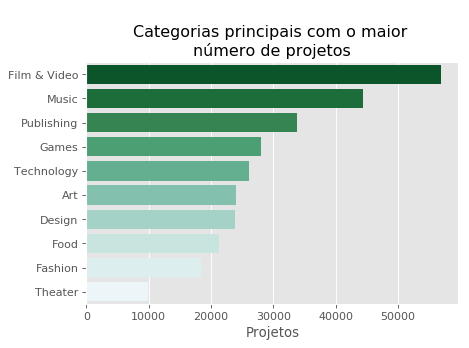

In [17]:
#Ploatndo um gráfico com as categorias principais com mais projetos:
fig = plt.figure(dpi=80)
ax  = sns.barplot(x = Top_Main_categories.values, y = Top_Main_categories.index, palette="BuGn_r", data = df)
plt.xlabel("Projetos")
plt.title("\nCategorias principais com o maior \nnúmero de projetos")
plt.show()

### Análise das categorias mais recorrentes:

In [18]:
#Encontrando as 10 categorias com maior número de projetos:
Top_categories = df.category.value_counts().head(10)

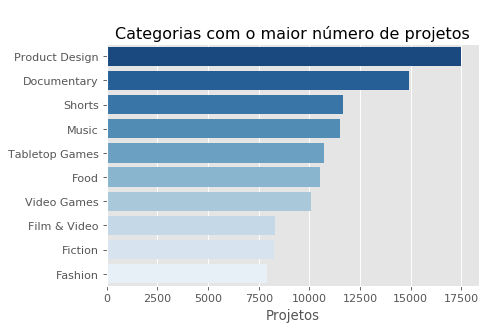

In [19]:
#Ploatndo um gráfico com as categorias principais com mais projetos:
fig = plt.figure(dpi = 80)
ax  = sns.barplot(x = Top_categories.values, y = Top_categories.index, palette="Blues_r", data = df)
plt.xlabel("Projetos")
plt.title("\nCategorias com o maior número de projetos")
plt.show()

### Análise da taxa de sucesso entre as categorias principais:

In [20]:
Top_Main_categories = dict(Top_Main_categories)

#calculando porcentagem de projetos que atingiram a meta por categoria:
def calcula_prob(categoria):
    return len(df[(df.main_category==categoria)&(df.state == "successful")])/len(df[(df.main_category == categoria)])

#criando listas para atribuir os valores da porcentagem dos projetos bem sucedidos:
probabilidade_categoria = []
porcentagem_categoria = []

#Atribuindo os nomes das categorias a uma variável em forma de lista:
nome_categoria = list(Top_Main_categories.keys())

In [21]:
#Criando um loop para atribuir os valores da porcentagem na lista:
for i in Top_Main_categories:
    probabilidade_categoria.append(calcula_prob(i))

for e in probabilidade_categoria:
    porcentagem_categoria.append(e*100)

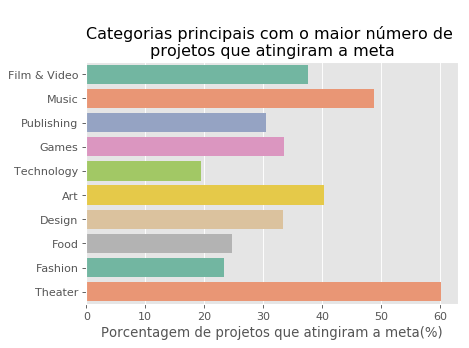

In [22]:
#Plotando o gráfico da porcentagem de sucesso para cada categoria principal:
fig = plt.figure(dpi=80)
ax  = sns.barplot(x = porcentagem_categoria, y = nome_categoria, palette= "Set2", data = df)
plt.xlabel("Porcentagem de projetos que atingiram a meta(%)")
plt.title("\nCategorias principais com o maior número de \nprojetos que atingiram a meta")
plt.show()

Ao análisar a quantidade de projetos nas categorias principais e nas gerais é possivel perceber algumas delas se repetem, assim estas têm as maiores porcentagens de sucesso dentre as categorias com as maiores quantidades de projetos, tirando "theater"que nao se repete explicitamente mas tem a maior taxa de sucesso.

<br>

### Análise dos paises de maior número de projetos

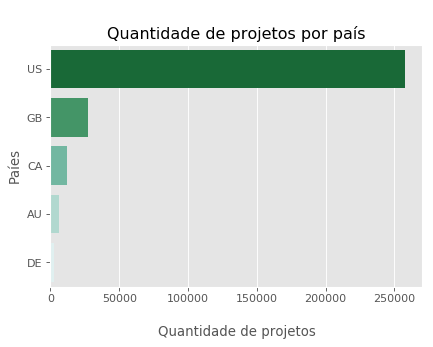

In [23]:
Top_Country = df.country.value_counts().head(5)
fig = plt.figure(dpi = 80)
ax  = sns.barplot(x = Top_Country.values, y = Top_Country.index, palette="BuGn_r", data = df);
plt.title("\nQuantidade de projetos por país")
plt.ylabel("Paíes")
plt.xlabel("\nQuantidade de projetos")
plt.show()

<br>

### Análise unidades monetárias mais utilizadas em projetos do kickstarter:

In [24]:
currency_type = df['currency'].value_counts();
currency_type

USD                 257562
GBP                  27508
CAD                  11992
EUR                  11369
AUD                   6236
SEK                   1269
NZD                   1136
DKK                    825
Não especificado       564
NOK                    526
CHF                    471
MXN                    214
SGD                    119
HKD                     97
Art                     63
Name: currency, dtype: int64

**O dolar americano esta na frente das outras moedas, seguido pela libra esterlina e pelo dolar canadense.**



<br>

## Quantia prometida para cada projeto (pledged):

In [25]:
#Transformando 'pledged' que até o momento é um objeto em uma variável numérica:
df['pledged'] = pd.to_numeric(df.pledged, downcast='integer', errors='coerce')

#Preenchendo os NANs deixados pelo coerce:
df = df.fillna(0)

#Atribuindo os valores de pledged no dataframe que será analisado:
ddf['pledged'] = np.log10(df.pledged)

#Restringindo os valores de pledged que serão analisados:
df = df[df.pledged > 0]

/Users/guilherme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


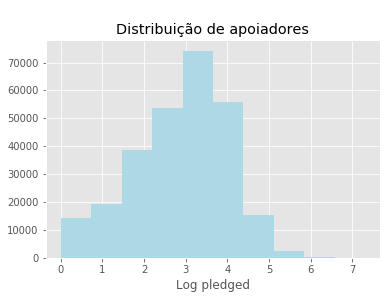

In [26]:
#Plotando o histogtrama de pledged:
plt.hist(np.log10(df.pledged), bins=10, color='lightblue');

plt.title('\nDistribuição de apoiadores')
plt.xlabel('Log pledged')
plt.show()

### Análise da quantidade de apoiadores dos projetos:

In [27]:
#Transformando 'backers' que até o momento é um objeto em uma variável numérica:
df['backers'] = pd.to_numeric(df.backers, downcast='integer', errors='coerce')

#Restringindo os valores de backers que serão analisados:
df = df[(df.backers >=1)]

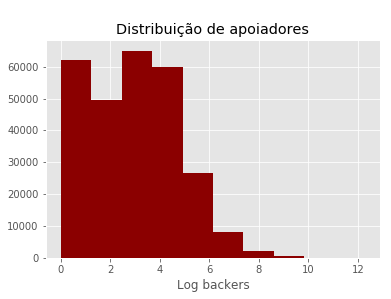

In [28]:
#Plotando o histogtrama de Backers:
plt.hist(np.log(df.backers), bins=10, color='Darkred');

plt.title('\nDistribuição de apoiadores')
plt.xlabel('Log backers')
plt.show()

### Análise dos objetivos dos projetos:

In [29]:
#Transformando 'goal' que até o momento é um objeto em uma variável numérica:
df['goal'] = pd.to_numeric(df.goal, downcast='float', errors='coerce')

#Preenchendo os NANs deixados pelo coerce:
df = df.fillna(value=0)

#Atribuindo os valores de goal no dataframe que será analisado:
ddf['goal'] = np.log10(df.goal)

df = df[(df.goal > 0)]

/Users/guilherme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


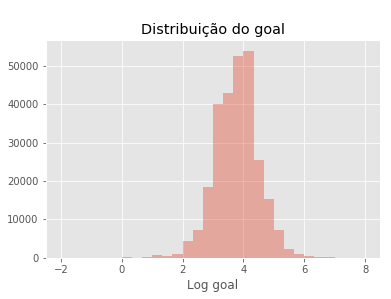

In [30]:
#Plotando a distribuição do goal:
g = sns.distplot(np.log10(df.goal), kde=False, bins=30)

plt.title('\nDistribuição do goal')
plt.xlabel('Log goal')
plt.show()

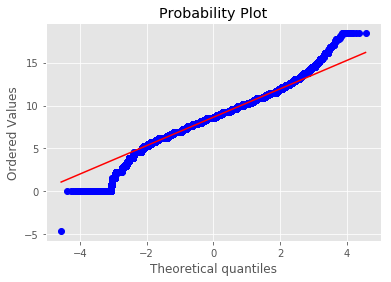

In [31]:
#Conferindo a destribuição de goal:
probplot(np.log(df.goal), dist="norm", plot=plt);



## Modelando:

### implementando o classificador:

Esse classificador pega algumas categorias, e com base nelas tenta atingir um alvo definido previamente, por meio de ramificações, que, calculando probabilidades, vão ficando cada vez menores, e mais detalhadas.

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [33]:
#Dividindo os dados do dataframe em teste e treino:
X_train, X_test, y_train, y_test = train_test_split(dff, ddf['state_successful'], test_size = 0.33, random_state = 0)                           

#Chamando o classificador:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, 
                               max_depth=8, min_samples_leaf=4)
#Fazendo um fit nos dados de treino:
clf_gini.fit(X_train, y_train)   

y_pred = clf_gini.predict(X_test)

#Descobrindo a acurácia do classificador:
acc = accuracy_score(y_test, y_pred)

acc = acc*100
print("A acurácia é de {:.2f}%".format(acc))

A acurácia é de 66.49%


### Implementando o RandomForest:

Este classificador é um estimador que se ajusta a vários classificadores de árvore de decisão em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. O tamanho da subamostra é sempre igual ao tamanho da amostra de entrada original, mas as amostras são desenhadas com substituição se bootstrap for usado.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/guilherme/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

#Dividindo os dados do dataframe em teste e treino:
X_train, X_test, y_train, y_test = train_test_split(dff, ddf['state_successful'], test_size=0.33, random_state=RANDOM_SEED)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

x_logistica = np.linspace(-10, 10, 500)
y_logistica = 1/(1 + np.exp(-x_logistica))
#Chamando o RandomForestClassifier:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Descobrindo a acurácia:
print('A acurácia é de: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

A acurácia é de: 66.20%


## Referências:

- https://www.kaggle.com/kabure/kickstarter-interactive-explanatory-exploration
- https://www.kaggle.com/rtatman/data-cleaning-challenge-character-encodings
- https://www.kaggle.com/rtatman/data-cleaning-challenge-scale-and-normalize-data
- https://www.kaggle.com/kabure/kickstarter-interactive-explanatory-exploration